##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Object detection with Model Garden
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/vision/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/vision/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/vision/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/vision/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial fine-tunes a [RetinaNet](https://arxiv.org/abs/1708.02002) with ResNet-50 as backbone model from the [TensorFlow Model Garden](https://pypi.org/project/tf-models-official/) package (tensorflow-models) to detect three different Blood Cells in [BCCD](https://public.roboflow.com/object-detection/bccd) dataset. The RetinaNet is pretrained on [COCO](https://cocodataset.org/) train2017 and evaluated on [COCO](https://cocodataset.org/) val2017

[Model Garden](https://www.tensorflow.org/tfmodels) contains a collection of state-of-the-art models, implemented with TensorFlow's high-level APIs. The implementations demonstrate the best practices for modeling, letting users to take full advantage of TensorFlow for their research and product development.

This tutorial demonstrates how to:

1. Use models from the Tensorflow Model Garden(TFM) package.
2. Fine-tune a pre-trained RetinanNet with ResNet-50 as backbone for object detection.
3. Export the tuned RetinaNet model

## Install necessary dependencies

In [1]:
!pip install -U -q "tensorflow" "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 37.1 MB/s eta 0:00:00


## Import required libraries

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

## Import required libraries from tensorflow models

In [3]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.13.0


## Custom dataset preparation for object detection

Models in official repository(of model-garden) requires data in a TFRecords format.


Please check [this resource](https://www.tensorflow.org/tutorials/load_data/tfrecord) to learn more about TFRecords data format.


### clone the model-garden repo as the required data conversion codes are within this model-garden repository

In [4]:
!git clone --quiet https://github.com/tensorflow/models.git

### Upload your custom data in drive or local disk of the notebook and unzip the data

In [5]:
!curl -L 'https://public.roboflow.com/ds/ZpYLqHeT0W?key=ZXfZLRnhsc' > './BCCD.v1-bccd.coco.zip'
!unzip -q -o './BCCD.v1-bccd.coco.zip' -d './BCC.v1-bccd.coco/'
!rm './BCCD.v1-bccd.coco.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0   1176      0 --:--:-- --:--:-- --:--:--  1176
100 15.2M  100 15.2M    0     0   9.9M      0  0:00:01  0:00:01 --:--:-- 40.4M


### Change directory to vision or data where data conversion tools are available

In [6]:
%cd ./models/

/content/models


### CLI command to convert data(train data).

In [8]:
%%bash

TRAIN_DATA_DIR='../BCC.v1-bccd.coco/train'
TRAIN_ANNOTATION_FILE_DIR='../BCC.v1-bccd.coco/train/_annotations.coco.json'
OUTPUT_TFRECORD_TRAIN='../bccd_coco_tfrecords/train'

# Need to provide
  # 1. image_dir: where images are present
  # 2. object_annotations_file: where annotations are listed in json format
  # 3. output_file_prefix: where to write output convered TFRecords files
python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${TRAIN_DATA_DIR} \
  --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
  --output_file_prefix=$OUTPUT_TFRECORD_TRAIN \
  --num_shards=1

2023-09-18 11:50:31.653763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0918 11:50:34.932791 134207379247104 create_coco_tf_record.py:502] writing to output path: ../bccd_coco_tfrecords/train
I0918 11:50:35.065713 134207379247104 create_coco_tf_record.py:374] Building bounding box index.
I0918 11:50:35.070650 134207379247104 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0918 11:50:35.837239 134207379247104 tfrecord_lib.py:168] On image 0
I0918 11:50:35.848006 134207379247104 tfrecord_lib.py:168] On image 100
I0918 11:50:35.856361 134207379247104 tfrecord_lib.py:168] On image 200
I0918 11:50:35.864623 134207379247104 tfrecord_lib.py:168] On image 300
I0918 11:50:35.872976 134207379247104 tfrecord_lib.py:168] On image 400
I0918 11:50:35.882265 134207379247104 tfrecord_lib.py:168] On image 500
I0918 11:50:35.890392 134207379247104 tfrecord_lib.py:168] On image 600
I0918 11:50:35.898712 134207379247104 tfrecord_lib.py:168] 

### CLI command to convert data(validation data).

In [9]:
%%bash

VALID_DATA_DIR='../BCC.v1-bccd.coco/valid'
VALID_ANNOTATION_FILE_DIR='../BCC.v1-bccd.coco/valid/_annotations.coco.json'
OUTPUT_TFRECORD_VALID='../bccd_coco_tfrecords/valid'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$VALID_DATA_DIR \
  --object_annotations_file=$VALID_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_VALID \
  --num_shards=1

2023-09-18 11:50:52.663227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0918 11:50:57.303175 139399226191872 create_coco_tf_record.py:502] writing to output path: ../bccd_coco_tfrecords/valid
I0918 11:50:57.313837 139399226191872 create_coco_tf_record.py:374] Building bounding box index.
I0918 11:50:57.314144 139399226191872 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0918 11:50:57.379511 139399226191872 tfrecord_lib.py:168] On image 0
I0918 11:50:57.394977 139399226191872 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.
I0918 11:50:57.396085 139399226191872 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


### CLI command to convert data(test data).

In [10]:
%%bash

TEST_DATA_DIR='../BCC.v1-bccd.coco/test'
TEST_ANNOTATION_FILE_DIR='../BCC.v1-bccd.coco/test/_annotations.coco.json'
OUTPUT_TFRECORD_TEST='../bccd_coco_tfrecords/test'

python -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=$TEST_DATA_DIR \
  --object_annotations_file=$TEST_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_TEST \
  --num_shards=1

2023-09-18 11:51:09.961626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0918 11:51:14.356880 137136245768192 create_coco_tf_record.py:502] writing to output path: ../bccd_coco_tfrecords/test
I0918 11:51:14.360826 137136245768192 create_coco_tf_record.py:374] Building bounding box index.
I0918 11:51:14.361050 137136245768192 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0918 11:51:14.407529 137136245768192 tfrecord_lib.py:168] On image 0
I0918 11:51:14.421076 137136245768192 tfrecord_lib.py:180] Finished writing, skipped 0 annotations.
I0918 11:51:14.421779 137136245768192 create_coco_tf_record.py:537] Finished writing, skipped 0 annotations.


## Configure the Retinanet Resnet FPN COCO model for custom dataset.

Dataset used for fine tuning the checkpoint is Blood Cells Detection (BCCD).

In [11]:
train_data_input_path = '../bccd_coco_tfrecords/train-00000-of-00001.tfrecord'
valid_data_input_path = '../bccd_coco_tfrecords/valid-00000-of-00001.tfrecord'
test_data_input_path = '../bccd_coco_tfrecords/test-00000-of-00001.tfrecord'
model_dir = '../trained_model/'
export_dir ='../exported_model/'

In Model Garden, the collections of parameters that define a model are called *configs*. Model Garden can create a config based on a known set of parameters via a [factory](https://en.wikipedia.org/wiki/Factory_method_pattern).


Use the `retinanet_resnetfpn_coco` experiment configuration, as defined by `tfm.vision.configs.retinanet.retinanet_resnetfpn_coco`.

The configuration defines an experiment to train a RetinanNet with Resnet-50 as backbone, FPN as decoder. Default Configuration is trained on [COCO](https://cocodataset.org/) train2017 and evaluated on [COCO](https://cocodataset.org/) val2017.

There are also other alternative experiments available such as
`retinanet_resnetfpn_coco`, `retinanet_spinenet_coco`, `fasterrcnn_resnetfpn_coco` and more. One can switch to them by changing the experiment name argument to the `get_exp_config` function.

We are going to fine tune the Resnet-50 backbone checkpoint which is already present in the default configuration.

In [12]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

### Adjust the model and dataset configurations so that it works with custom dataset(in this case `BCCD`).

In [13]:
batch_size = 8
num_classes = 3

HEIGHT, WIDTH = 256, 256
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

### Adjust the trainer configuration.

In [14]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 1000
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

Running on CPU is slow, so only train for a few steps.


### Print the modified configuration.

In [15]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
     

<IPython.core.display.Javascript object>

### Set up the distribution strategy.

In [16]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

Done


## Create the `Task` object (`tfm.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The `Task` object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.

In [17]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

## Visualize a batch of the data.

In [18]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')


images.shape: (8, 256, 256, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


### Create category index dictionary to map the labels to coressponding label names.

In [20]:
category_index={
    1: {
        'id': 1,
        'name': 'Platelets'
       },
    2: {
        'id': 2,
        'name': 'RBC'
       },
    3: {
        'id': 3,
        'name': 'WBC'
       }
}
tf_ex_decoder = TfExampleDecoder()

### Helper function for visualizing the results from TFRecords.
Use `visualize_boxes_and_labels_on_image_array` from `visualization_utils` to draw boudning boxes on the image.

In [19]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

### Visualization of train data

The bounding box detection has two components
  1. Class label of the object detected (e.g.RBC)
  2. Percentage of match between predicted and ground truth bounding boxes.

**Note**: The reason of everything is 100% is because we are visualising the groundtruth.

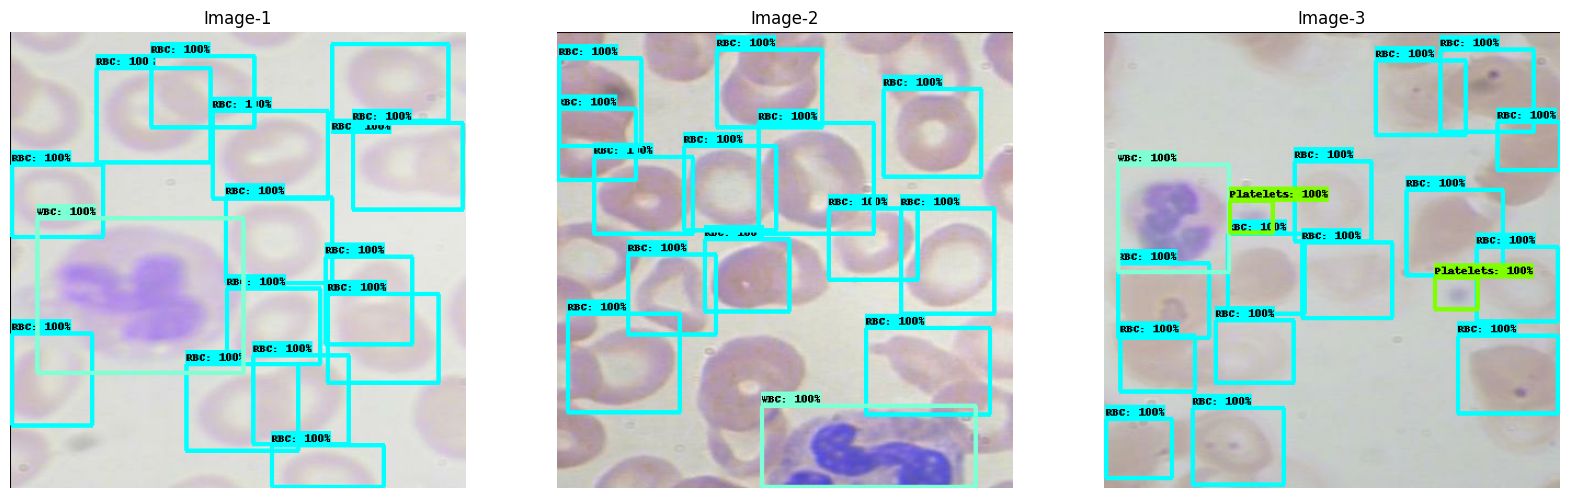

In [21]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

## Train and evaluate.

We follow the COCO challenge tradition to evaluate the accuracy of object detection based on mAP(mean Average Precision). Please check [here](https://cocodataset.org/#detection-eval) for detail explanation of how evaluation metrics for detection task is done.

**IoU**: is defined as the area of the intersection divided by the area of the union of a predicted bounding box and ground truth bounding box.

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
train | step:      0 | training until step 100...


## Load logs in tensorboard.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '../trained_model/'

## Saving and exporting the trained model.

The `keras.Model` object returned by `train_lib.run_experiment` expects the data to be normalized by the dataset loader using the same mean and variance statiscics in `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`. This export function handles those details, so you can pass `tf.uint8` images and get the correct results.

In [ ]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

## Inference from trained model

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

### Visualize test data.

In [ ]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    '../bccd_coco_tfrecords/test-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

### Importing SavedModel.

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### Visualize predictions.

In [ ]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.30 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()